In [1]:
# Set up parameters for image generation
width=256
height=256
positive_signal_level = 0.5 # how much signal to add for positive and negative observations
negative_signal_level = 0.5 # how much signal to add for positive and negative observations
noise_level = 0.1 # how much noise to add
spurious_activity = 100
error_probability = 0.05 # the probability of making an error for individual points

Matplotlib is building the font cache; this may take a moment.


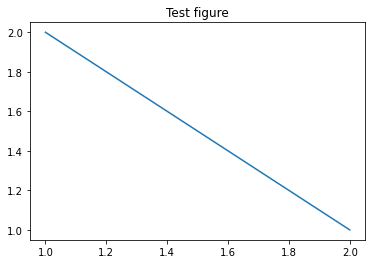

In [2]:
# plotting

from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.title("Test figure")
plt.plot([1, 2], [2, 1])

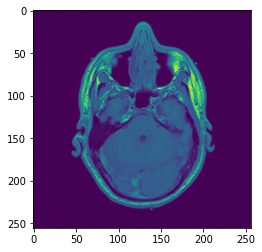

In [3]:
# Import an image!
import matplotlib.image as mpimg
img=mpimg.imread('../../data/fmri/mri-test1.png')
plt.imshow(img)
x_dimension = img.shape[0]
y_dimension = img.shape[1]

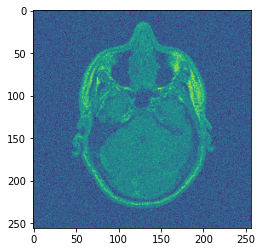

In [4]:
# Add noise to it
import numpy as np
noise = np.random.normal(size=img.shape, scale=noise_level)
plt.imshow(img + noise)

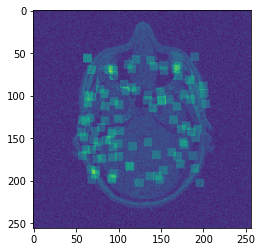

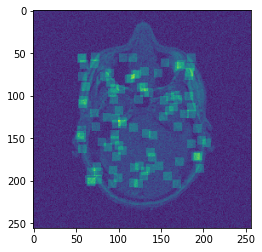

In [5]:
#OK, let us now use this idea to create two types of images.
def generate_image(xloc, yloc, signal, noise, spurious_activity, src_img):
    img= src_img.copy() + np.random.normal(size=src_img.shape, scale=noise)
    img[xloc:xloc+10,yloc:yloc+10] += signal
    for i in range(spurious_activity):
        xrand = int(np.random.uniform(50,200))
        yrand = int(np.random.uniform(50,200))
        img[xrand:xrand+10,yrand:yrand+10] += signal
    return img

plt.figure(1)
plt.imshow(generate_image(150, 130, signal=positive_signal_level, noise=noise_level, spurious_activity=spurious_activity, src_img=img))
plt.figure(2)
plt.imshow(generate_image(160, 100, signal=negative_signal_level, noise=noise_level, spurious_activity=spurious_activity, src_img=img))

In [13]:
# Create a few example images
n_subjects = 100
n_positive = 10
n_negative = 10

import pandas as pd
data = pd.DataFrame()
labels = np.empty(n_subjects*(n_positive + n_negative))
i = 0
for subject in range(n_subjects):
    positive_x = np.int(160 + np.random.random_sample()*30)
    positive_y = np.int(100 + np.random.random_sample()*30)
    negative_x = np.int(150 + np.random.random_sample()*30)
    negative_y = np.int(130 + np.random.random_sample()*30)
    for k in range(n_positive):
        X = generate_image(positive_x, positive_y, signal=positive_signal_level, noise=noise_level, spurious_activity=spurious_activity, src_img=img)
        data = data.append(pd.Series(X.reshape(-1)), ignore_index=True)
        labels[i] = 1; i+=1
    for k in range(n_negative):
        X = generate_image(negative_x, negative_y, signal=positive_signal_level, noise=noise_level, spurious_activity=spurious_activity, src_img=img)
        data = data.append(pd.Series(X.reshape(-1)), ignore_index=True)
        labels[i] = 0; i+=1

# add a new column with the labels
#full_data = data
#full_data['label'] = labels

In [14]:
n_examples = data.shape[0]
total_positive = 0
total_negative = 0
mean_positive = np.empty([x_dimension, y_dimension])
mean_negative = np.empty([x_dimension, y_dimension])

for i in range(n_examples):
    example = data.iloc[[i]].values.reshape(x_dimension, y_dimension)
    if (labels[i]==1):        
        mean_positive += example
        total_positive +=1
    else:
        mean_negative += example
        total_negative +=1
        
mean_positive /= total_positive
mean_negative /= total_negative


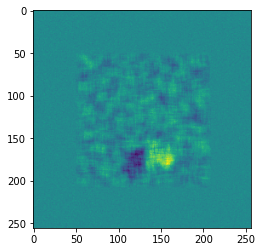

In [15]:
plt.figure(1); plt.imshow(mean_negative-mean_positive)
deltas = (mean_negative - mean_positive)/2


Rate of discoveries:  2.2857666015625


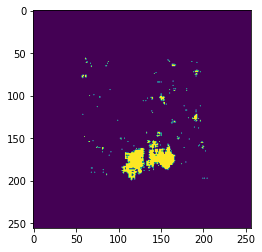

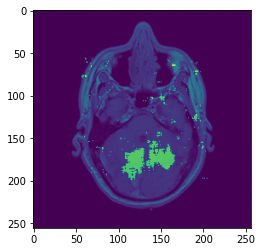

In [29]:
import scipy.stats

error_probability = 0.000000000000001 # the probability of making an error for individual points
# Calculate the tails so that the probability of finding a positive signal where there is none is 'error_probability' for each pixel
tail = scipy.stats.norm.interval(1 - error_probability, scale= noise_level / np.sqrt(n_examples))
features = np.empty([x_dimension, y_dimension])
#for x in range(x_dimension):
#    for y in range(y_dimension):
#        if (deltas[x][y] < tail[0] or deltas[x][y] > tail[1]):
#            features[x][y] = 1
#        else:
#            features[x][y] = 0
features = (deltas < tail[0]) + deltas > tail[1]
plt.figure(1)
plt.imshow(features)
plt.figure(2)
plt.imshow(features + img)
print("Rate of discoveries: ", 100 * np.sum(features>0) / (x_dimension*y_dimension))
